In [1]:
import tensorflow as tf 
import tensorflow_probability as tfp
from tensorflow.keras.datasets import mnist

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

import argparse
import random
import os

tfd = tfp.distributions

/Users/sakaya/ml-env/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/sakaya/ml-env/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
import importlib
import custom_layers
import utilities

In [4]:
# Hyperparameter setup
learning_rate = 0.001
epochs = 100
batch_size = 128
num_classes = 10
num_samples = 1

n_samples = 5000 # number of MNIST samples

### MNIST data (5000 train, 5000 val and 10000 test) with 50% noise in training data

In [19]:
# # Load and preprocess MNIST data
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.reshape([-1, 28*28])
# x_test = x_test.reshape([-1, 28*28])
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

# y_train = y_train.astype('int32')
# y_test = y_test.astype('int32')

# train_samples = x_train.shape[0]
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')

# x_val, y_val = x_test, y_test

I = np.eye(num_classes)
x_train_S, y_train_S, x_test, y_test = utilities.load_mnist(n_samples, square=False, conv=False)
y_train_S = y_train_S.astype('int32')
y_test = y_test.astype('int32')

N = int(n_samples/2)

x_val = x_train_S[N:]
y_val = y_train_S[N:]

x_train = x_train_S[:N]
y_train = y_train_S[:N]

# Add output noise to important class
R = int(.5*N)
r_ind = random.sample(range(0,N),R)
r_class = np.random.randint(0,num_classes,R)
y_train[r_ind] = r_class

train_samples = N

x_train shape: (5000, 784)
5000 train samples
10000 test samples


### Loss matrix 

In [20]:
digits = [3,8]
np.set_printoptions(precision=3)
L = np.copy(I)
L[np.where(I==0)] = 1
L[[3,8]] = 0.7 # Select more important rows with lower loss in prediction
L[np.where(I==1)] = 0

loss_mat = L
M = 1.0001

print("         TRUTH\n" )
string = 'PRED'
for i in range(num_classes):
    if i < 4:
        print(string[i],'  ',str(i),': ',M - loss_mat[i])
    else:
        print('    ',str(i),': ',M - loss_mat[i])
        
# Set up weight for weighted cross entropy

class_weight = np.ones((num_classes))
class_weight[digits] = 1.4

print(loss_mat)

         TRUTH

P    0 :  [1.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
R    1 :  [1.e-04 1.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
E    2 :  [1.e-04 1.e-04 1.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
D    3 :  [0.3 0.3 0.3 1.  0.3 0.3 0.3 0.3 0.3 0.3]
     4 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e+00 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04]
     5 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e+00 1.e-04 1.e-04 1.e-04 1.e-04]
     6 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e+00 1.e-04 1.e-04 1.e-04]
     7 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e+00 1.e-04 1.e-04]
     8 :  [0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 1.  0.3]
     9 :  [1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e-04 1.e+00]
[[0.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  0.  1.  1.  1.  1.  1.  1.  1.  1. ]
 [1.  1.  0.  1.  1.  1.  1.  1.  1.  1. ]
 [0.7 0.7 0.7 0.  0.7 0.7 0.7 0.7 0.7 0.7]
 [1.  1.  1.  1.  0.  1.  1.  1.  1.  1. ]
 [1.  1. 

### Softmax loss

In [21]:

# Scale the KL term from the probabilistic layers for per-datapoint ELBO. 
# KL term added internally as a regularization term.
scaled_kl = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(train_samples, tf.float32)

x_input =  tf.keras.Input((x_train.shape[1:]), name = 'x_input')
y_input =  tf.keras.Input((1,), name = 'y_input')

logits = custom_layers.Softmax( 
    10, 
    kernel_divergence_fn=scaled_kl)([x_input, y_input])

model_sm = tf.keras.Model([x_input, y_input], logits)
model_sm.compile(loss=None, optimizer='adam')

In [22]:

history_model_sm = []
for epoch in range(epochs):
    history_epoch = model_sm.fit([x_train, y_train],
                 batch_size=batch_size,
                 epochs=1,
                 verbose=1,
                 validation_data=([x_val, y_val], None))
#                  callbacks=[model_checkpoint])
#     T = 10
#     yt_hat = np.array([lc_model.predict([x_train,H_x]) for _ in range(T)])
#     H_x = lcbnn.optimal_h(yt_hat,loss_mat)
#     h_train = np.argmax(model.predict([x_train, y_train, h_train]), -1)
    history_model_sm.append(history_epoch)
       

Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 1s 239us/step - loss: 10.6373 - val_loss: 10.2688
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 31us/step - loss: 10.2694 - val_loss: 9.8564
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 38us/step - loss: 10.0721 - val_loss: 9.5302
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 60us/step - loss: 9.9341 - val_loss: 9.3283
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 37us/step - loss: 9.8170 - val_loss: 9.1607
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 48us/step - loss: 9.7509 - val_loss: 9.0645
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==========================

2500/2500 [==============================] - 0s 27us/step - loss: 7.3825 - val_loss: 6.8009
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 57us/step - loss: 7.3362 - val_loss: 6.7392
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 116us/step - loss: 7.3141 - val_loss: 6.6992
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 103us/step - loss: 7.2379 - val_loss: 6.7009
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 73us/step - loss: 7.2285 - val_loss: 6.6303
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 27us/step - loss: 7.1800 - val_loss: 6.5888
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 26us/step - loss: 7.1432 - val_loss: 6.5649
Train 

In [9]:
y_pred = np.argmax(model_sm.predict([x_test,y_test]), 1)
print("Test accuracy: ", len(np.where(y_pred - y_test == 0)[0])/len(y_test))

y_pred = np.argmax(model_sm.predict([x_train, y_train]), 1)
print("Train accuracy: ", len(np.where(y_pred - y_train == 0)[0])/len(y_train))

Test accuracy:  0.9186
Train accuracy:  0.9255166666666667


### Loss calibrated softmax loss

In [27]:
# For reproduceable results
importlib.reload(custom_layers)
importlib.reload(utilities)

# Scale the KL term from the probabilistic layers for per-datapoint ELBO. 
# KL term added internally as a regularization term.

scaled_kl = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(train_samples, tf.float32)

x_input =  tf.keras.Input((x_train.shape[1:]), name = 'x_input')
y_input =  tf.keras.Input((1,), name = 'y_input')
h_input =  tf.keras.Input((1,), name = 'h_input')

logits = custom_layers.LCSoftmax( 
    10, 
    M,
    loss_mat,
    kernel_divergence_fn=scaled_kl)([x_input, y_input, h_input])

model_sm_lc = tf.keras.Model([x_input, y_input, h_input], logits)
model_sm_lc.compile(loss=None, optimizer='adam')

In [28]:
h_train = y_train
h_test = y_test
h_val = y_val

history_model_sm_lc = []
for epoch in range(epochs):
    history_epoch = model_sm_lc.fit([x_train, y_train, h_train],
                 batch_size=batch_size,
                 epochs=1,
                 verbose=1,
                 validation_data=([x_val, y_val, h_val], None))
#                  callbacks=[model_checkpoint])
    T = 10
    yt_hat = np.array([model_sm_lc.predict([x_train, y_train, h_train]) for _ in range(T)])
    h_train = utilities.optimal_h(yt_hat, loss_mat)
    history_model_sm_lc.append(history_epoch)
       

Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 1s 274us/step - loss: 12.6593 - val_loss: 12.0833
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 28us/step - loss: 11.1781 - val_loss: 11.6722
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 52us/step - loss: 10.9057 - val_loss: 11.4548
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 90us/step - loss: 10.7934 - val_loss: 11.0014
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 32us/step - loss: 10.6661 - val_loss: 10.7250
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 66us/step - loss: 10.5768 - val_loss: 10.5312
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==================

2500/2500 [==============================] - 0s 31us/step - loss: 8.0828 - val_loss: 7.2706
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 31us/step - loss: 8.0458 - val_loss: 7.2388
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 30us/step - loss: 7.9833 - val_loss: 7.1875
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 33us/step - loss: 7.9524 - val_loss: 7.1639
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 35us/step - loss: 7.9411 - val_loss: 7.0978
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 49us/step - loss: 7.8830 - val_loss: 7.0612
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 42us/step - loss: 7.8438 - val_loss: 7.0349
Train on

### One-vs-each loss

In [23]:
# For reproduceable results
importlib.reload(custom_layers)
importlib.reload(utilities)
# np.random.seed(1337)

# Scale the KL term from the probabilistic layers for per-datapoint ELBO. 
# KL term added internally as a regularization term.

scaled_kl = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / tf.cast(train_samples, tf.float32)


x_input =  tf.keras.Input((x_train.shape[1:]), name = 'x_input')
y_input =  tf.keras.Input((1,), name = 'y_input')

logits = custom_layers.OVELayer(
    5,
    10, 
    kernel_divergence_fn=scaled_kl)([x_input, y_input])

model_ove = tf.keras.Model([x_input, y_input], logits)
model_ove.compile(loss=None, optimizer='adam')

In [24]:

history_model_ove = []
for epoch in range(epochs):
    history_epoch = model_ove.fit([x_train, y_train],
                 batch_size=batch_size,
                 epochs=1,
                 verbose=1,
                 validation_data=([x_val, y_val], None))
#                  callbacks=[model_checkpoint])

    history_model_ove.append(history_epoch)
       

Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 1s 364us/step - loss: 11.6706 - val_loss: 10.2022
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 43us/step - loss: 10.9147 - val_loss: 10.1367
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 63us/step - loss: 11.0898 - val_loss: 10.0716
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 68us/step - loss: 10.7627 - val_loss: 10.0132
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 42us/step - loss: 10.5254 - val_loss: 9.9610
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 86us/step - loss: 10.4311 - val_loss: 9.9181
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [====================

2500/2500 [==============================] - 0s 39us/step - loss: 8.2072 - val_loss: 8.1593
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 56us/step - loss: 8.0579 - val_loss: 8.1403
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 77us/step - loss: 8.0032 - val_loss: 8.0979
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 48us/step - loss: 8.0583 - val_loss: 8.0733
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 135us/step - loss: 7.9654 - val_loss: 8.0369
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 50us/step - loss: 8.0045 - val_loss: 8.0092
Train on 2500 samples, validate on 2500 samples
Epoch 1/1
2500/2500 [==============================] - 0s 47us/step - loss: 7.9808 - val_loss: 7.9808
Train o

## Risk evaluation

In [29]:
#  Softmax model

T = 10
yt_hat_std = np.array([model_sm.predict([x_test, y_test]) for _ in range(T)])
H_x_test_std = utilities.optimal_h(yt_hat_std,loss_mat) 
acc_std = accuracy_score(y_test, H_x_test_std)
loss_std = np.mean(loss_mat[y_test, H_x_test_std])
print('Standard:\n')
print('Accuracy on optimal decision: ', acc_std)
print('Expected loss: ', loss_std)


#  Softmax with loss calibration

T = 10
yt_hat_sm_lc = np.array([model_sm_lc.predict([x_test, y_test, h_test]) for _ in range(T)])
H_x_test_sm_lc = utilities.optimal_h(yt_hat_sm_lc,loss_mat) 
acc_sm_lc = accuracy_score(y_test, H_x_test_sm_lc)
loss_sm_lc = np.mean(loss_mat[y_test, H_x_test_sm_lc])
print('Loss calibrated softmax:\n')
print('Accuracy on optimal decision: ', acc_sm_lc)
print('Expected loss: ', loss_sm_lc)


# OVE model

T = 10 
yt_hat_ove = np.array([model_ove.predict([x_test, y_test]) for _ in range(T)])
H_x_test_ove = utilities.optimal_h(yt_hat_ove,loss_mat) 
acc_ove = accuracy_score(y_test, H_x_test_ove)
loss_ove = np.mean(loss_mat[y_test, H_x_test_ove])
print('\nOVE:\n')
print('Accuracy on optimal decision: ', acc_ove)
print('Expected loss: ', loss_ove)


Standard:

Accuracy on optimal decision:  0.6234
Expected loss:  0.36655
Loss calibrated softmax:

Accuracy on optimal decision:  0.7641
Expected loss:  0.2269

OVE:

Accuracy on optimal decision:  0.5667
Expected loss:  0.4243


Normalized confusion matrix
[[6.43e-01 1.02e-03 6.12e-03 1.95e-01 0.00e+00 4.08e-03 1.53e-02 8.16e-03
  1.26e-01 2.04e-03]
 [0.00e+00 7.67e-01 8.81e-04 1.22e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  1.09e-01 0.00e+00]
 [4.84e-03 4.46e-02 4.84e-01 2.70e-01 1.65e-02 9.69e-04 1.07e-02 1.26e-02
  1.50e-01 5.81e-03]
 [0.00e+00 3.96e-03 4.95e-03 9.04e-01 0.00e+00 2.18e-02 9.90e-04 1.58e-02
  4.55e-02 2.97e-03]
 [3.05e-03 0.00e+00 0.00e+00 2.24e-01 4.64e-01 4.07e-03 8.15e-03 1.02e-03
  2.57e-01 3.87e-02]
 [1.68e-02 1.01e-02 2.24e-03 2.61e-01 1.12e-03 4.74e-01 1.91e-02 7.85e-03
  1.79e-01 2.80e-02]
 [2.09e-03 6.26e-03 2.82e-02 1.27e-01 1.67e-02 1.46e-02 5.87e-01 3.13e-03
  2.11e-01 4.18e-03]
 [3.89e-03 9.73e-03 8.75e-03 2.70e-01 3.89e-03 1.95e-03 9.73e-04 5.90e-01
  5.74e-02 5.25e-02]
 [7.19e-03 2.05e-02 3.08e-03 1.58e-01 1.03e-03 1.03e-02 1.33e-02 6.16e-03
  7.67e-01 1.33e-02]
 [9.91e-04 1.98e-03 9.91e-04 1.92e-01 9.91e-03 3.96e-03 4.96e-03 1.49e-02
  1.98e-01 5.72e-01]]
Normalized confusion 

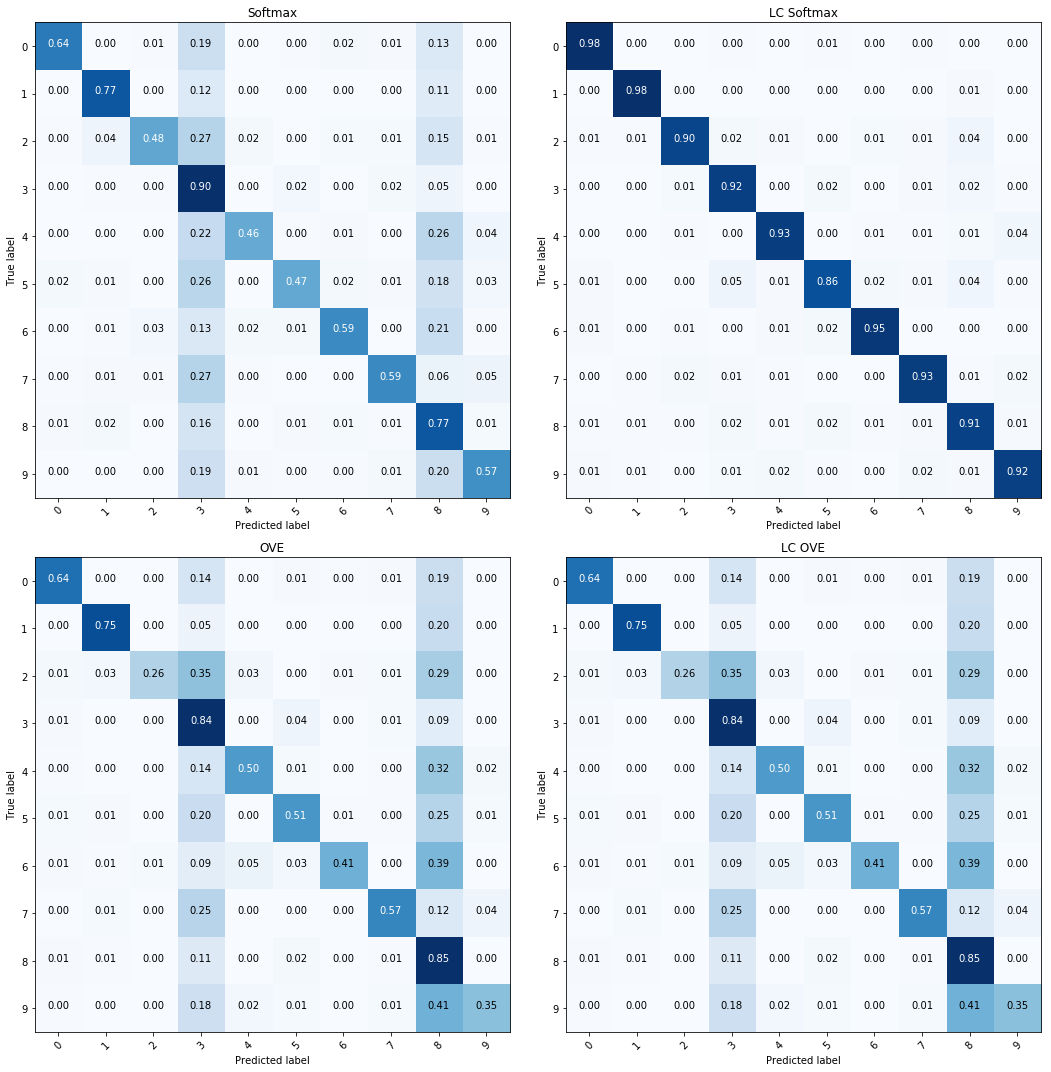

In [26]:
plt.rcParams['figure.figsize'] = (15, 15) # Width and height

classes = ['0','1','2','3','4','5','6','7','8','9']


cnf_matrix_std = confusion_matrix(y_test.astype('float'),np.round(H_x_test_std))
np.set_printoptions(precision=2)
cnf_matrix_sm_lc = confusion_matrix(y_test.astype('float'),np.round(H_x_test_sm_lc))
np.set_printoptions(precision=2)
cnf_matrix_ove = confusion_matrix(y_test.astype('float'),np.round(H_x_test_ove))
np.set_printoptions(precision=2)

plt.subplot(221)
utilities.plot_confusion_matrix(cnf_matrix_std, classes=classes, normalize=True,
                      title='Softmax')
plt.subplot(222)
utilities.plot_confusion_matrix(cnf_matrix_sm_lc, classes=classes, normalize=True,
                      title='LC Softmax')
plt.subplot(223)
utilities.plot_confusion_matrix(cnf_matrix_ove, classes=classes, normalize=True,
                      title='OVE')
plt.subplot(224)
utilities.plot_confusion_matrix(cnf_matrix_ove, classes=classes, normalize=True,
                      title='LC OVE')